# Install Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Dense

# Globals Variables

In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

def Classes_Count(path, name, emotions=['happy', 'sad']):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        if Class in emotions:  # Check if the class is one of the specified emotions
            Full_Path = os.path.join(path, Class)  # Use os.path.join for better compatibility
            Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

# Display the counts
print("Train Count:\n", Train_Count)
print("\nTest Count:\n", Test_Count)


Train Count:
        Train
happy   7215
sad     4830

Test Count:
        Test
happy  1774
sad    1247


In [4]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
sad,4830,1247


<Axes: >

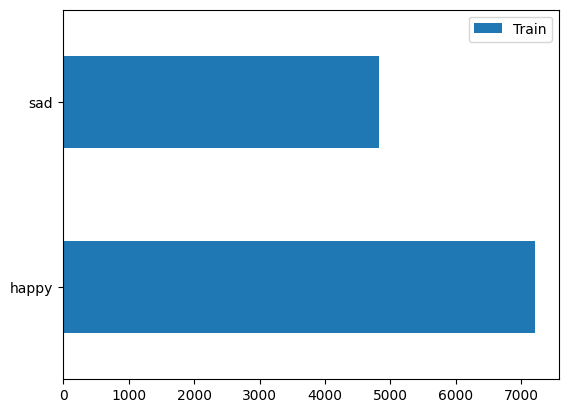

In [5]:
Train_Count.plot(kind='barh')

<Axes: >

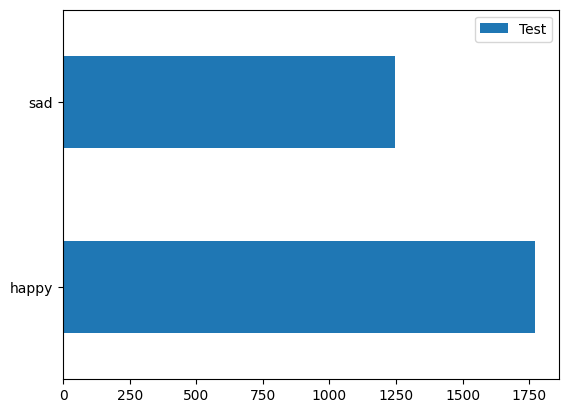

In [6]:
Test_Count.plot(kind='barh')

# ResNet50V2 Model

In [7]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

In [8]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    classes=['happy', 'sad'],
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    classes=['happy', 'sad'],
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 12045 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.


# Fine-Tuning ResNet50V2

In [9]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

ResNet50V2.summary()
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(2,activation='softmax')
                    ])
    return model
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

# Specifying Callbacks

In [10]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [11]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30


2023-12-03 05:41:25.191896: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


188/188 [==============================] - 193s 954ms/step - loss: 0.4005 - accuracy: 0.8514 - val_loss: 0.9234 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 177s 940ms/step - loss: 0.2768 - accuracy: 0.8937 - val_loss: 8.5183 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 176s 935ms/step - loss: 0.2248 - accuracy: 0.9109 - val_loss: 0.2217 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 177s 940ms/step - loss: 0.1938 - accuracy: 0.9267 - val_loss: 0.2468 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 5/30
188/188 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9286
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
188/188 [==============================] - 176s 933ms/step - loss: 0.1840 - accuracy: 0.9286 - val_loss: 0.2702 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 6/30
188/188 [==============================] - 

# Evaluating ResNet50V2

In [45]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)
print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

48/48 [==============================] - 31s 645ms/step - loss: 0.1803 - accuracy: 0.9470
    Test Loss: 0.18026
Test Accuracy: 94.70%


In [13]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

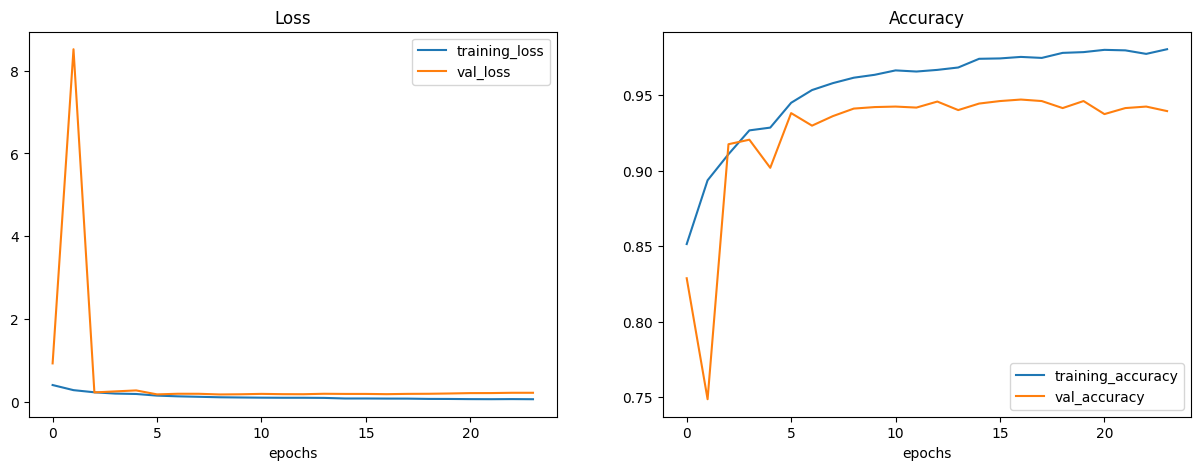

In [14]:
plot_curves(ResNet50V2_history)

In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

48/48 [==============================] - 9s 159ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

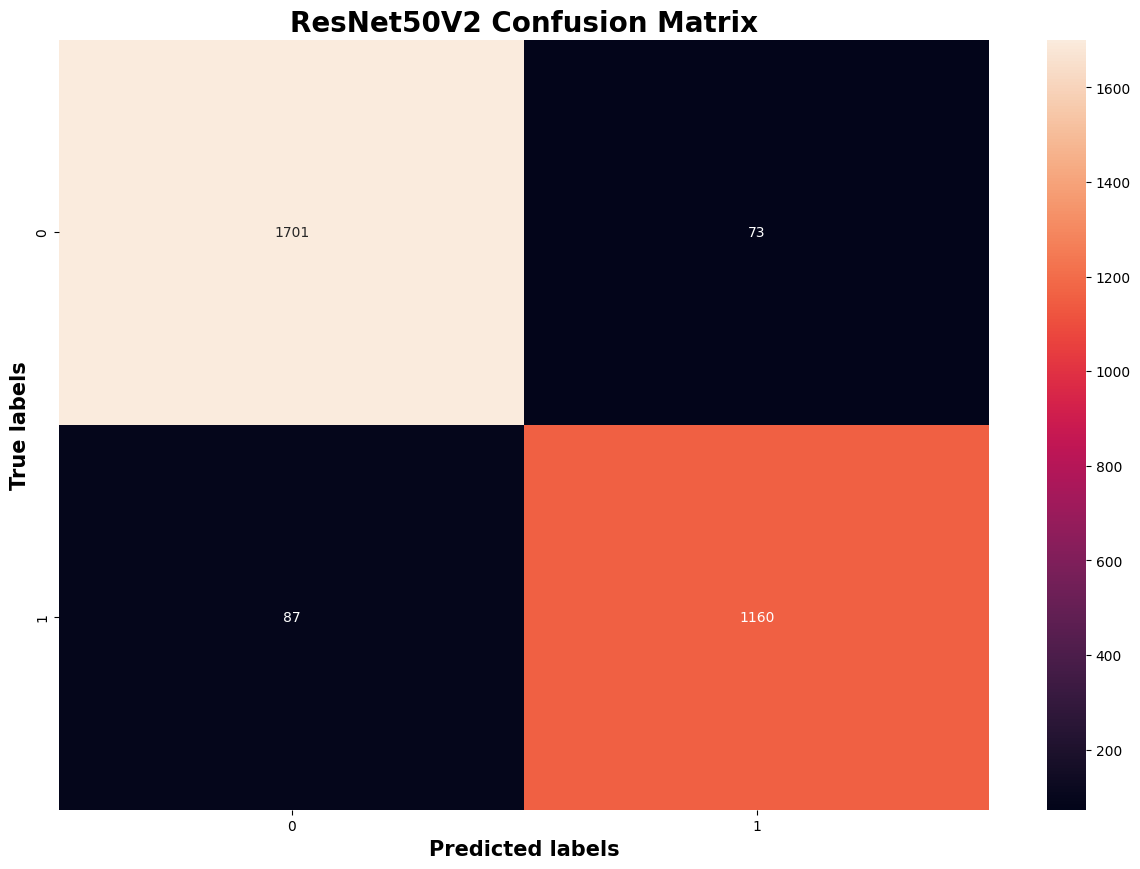

In [21]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# Visualizing Predictions

In [22]:
# Adjusted Emotion_Classes array
Emotion_Classes = ['Happy', 'Sad']

In [24]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    classes=['happy', 'sad'],
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 3021 images belonging to 2 classes.


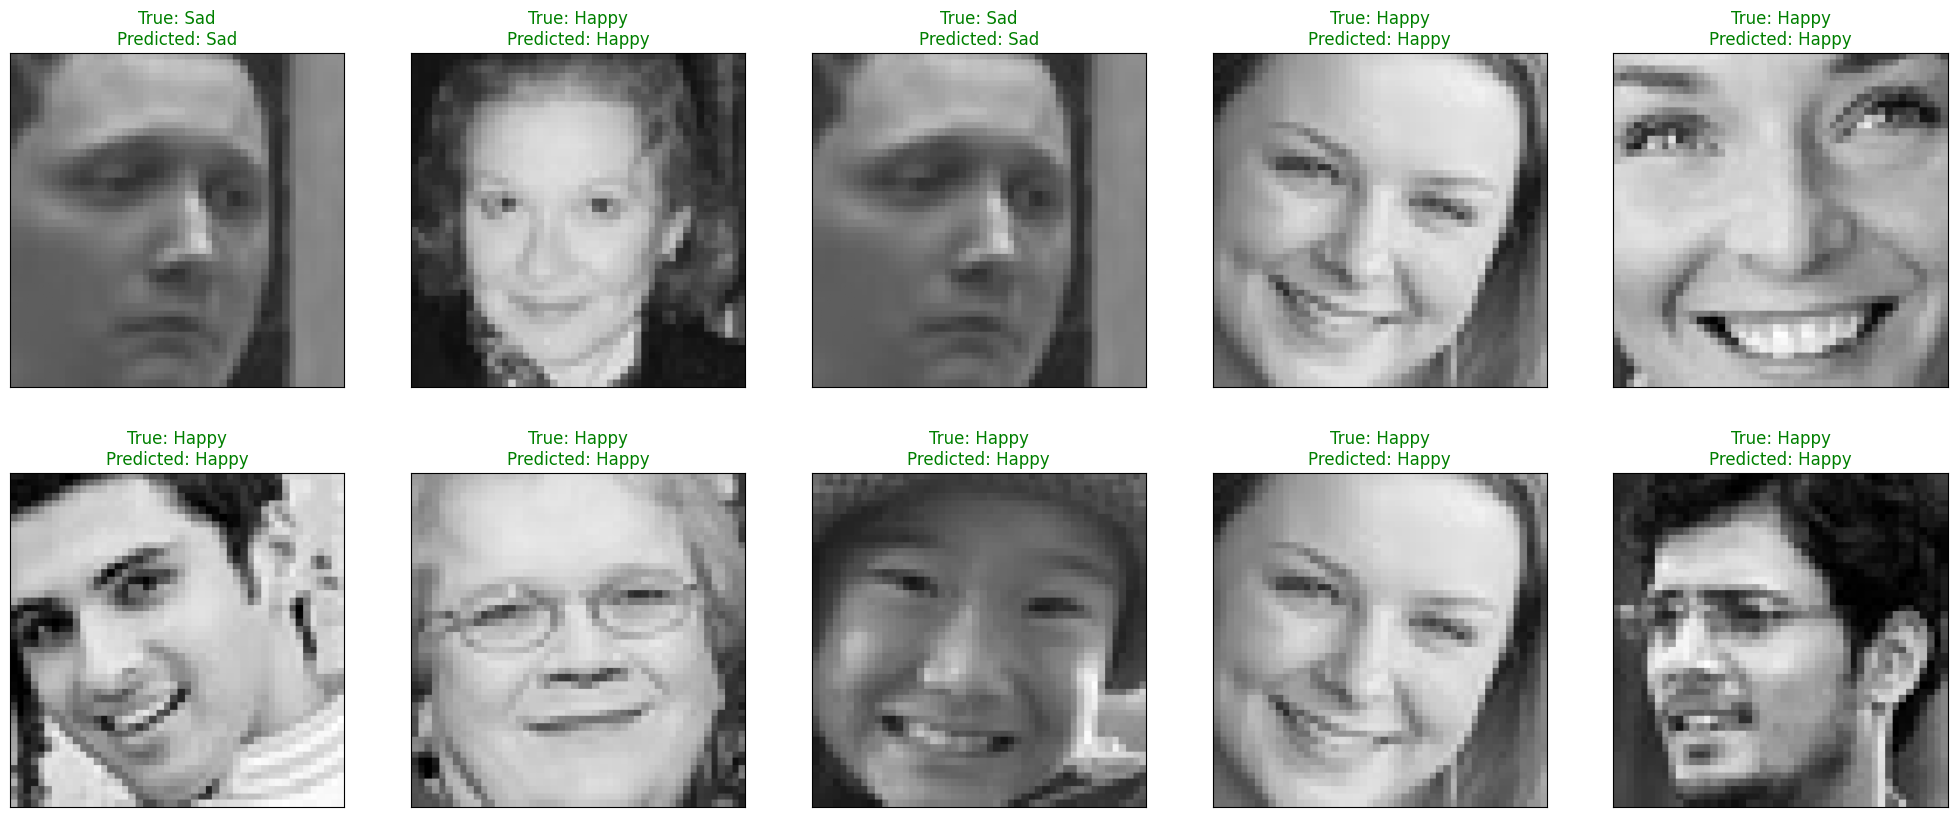

<Figure size 640x480 with 0 Axes>

In [25]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [30]:
Music_Player = pd.read_csv("/kaggle/input/data-moods-csv/data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [31]:
Music_Player["mood"].value_counts()

mood
Sad          197
Calm         195
Energetic    154
Happy        140
Name: count, dtype: int64

In [32]:
Music_Player["popularity"].value_counts()

popularity
0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: count, Length: 83, dtype: int64

In [33]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:5].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


In [43]:
import random

# Assuming Music_Player is a DataFrame with 'mood' and 'popularity' columns
def Recommend_Songs(pred_class):
    num_songs = 5

    # Check if the predicted class is 'happy' or 'sad'
    if pred_class in ['happy', 'sad']:
        # Filter by the corresponding mood, ignoring the 'Sad' category in the dataset
        if pred_class == 'sad':
            mood_filter = ['Calm', 'Energetic']  # Change this list as per your requirement
        else:
            mood_filter = ['Happy']

        Play = Music_Player[Music_Player['mood'].isin(mood_filter)]
        Play = Play.sort_values(by="popularity", ascending=False)

        # Ensure there are enough songs to recommend
        if len(Play) < num_songs:
            print("Not enough songs to recommend.")
            return

        # Randomly select songs, considering popularity
        top_songs = Play.head(int(len(Play) * 0.2))  # Top 20% popular songs
        other_songs = Play.iloc[int(len(Play) * 0.2):]  # Remaining 80% songs

        recommendations = top_songs.sample(min(num_songs, len(top_songs)), replace=False)
        if len(recommendations) < num_songs:
            recommendations = recommendations.append(other_songs.sample(num_songs - len(recommendations), replace=False))
        
        recommendations = recommendations.reset_index(drop=True)
        recommendations = recommendations.iloc[:, 0:3]
        display(recommendations)
    else:
        print("Invalid mood class. No recommendations available.")

# Example usage:
# Music_Player is your DataFrame containing songs with 'mood' and 'popularity'
# pred_class will be either 'happy' or 'sad' as per the prediction
Recommend_Songs(pred_class='sad')


,name,artist,mood
0,Papercut,Linkin Park,Energetic
1,Coda,Jakob Ahlbom,Calm
2,The Wall,Alok,Energetic
3,Always,Saliva,Energetic
4,Bottom of a Bottle,Smile Empty Soul,Energetic


In [48]:
ResNet50V2_Model.save('/kaggle/working/my_model.h5')